### Toy Network Testing Notebook

This notebook is for building out and testing functionality in a Toy Network, which should serve as a model for developing network tomography strategies.

In [1]:
import sys
sys.path.append('..')

import networkx as nx
from itertools import combinations
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from pathlib import Path
import pandas as pd
from copy import deepcopy
from sklearn.metrics.pairwise import euclidean_distances

# Make graph labels somewhat more legible
plt.rcParams.update({'font.size': 16})

# Enable verbose errors, to make debugging easier
%xmode Verbose

PROJECT_ROOT = Path.cwd().parent

Exception reporting mode: Verbose


As functions become well defined they are factored out into .py files that aggregate functionality pertaining to some aspect of the toy network. Currently, they are relocated as follows:

| File | Content |
| ---- | ------- |
| src/data/make_network.py | Functions for the creation and modification of a network |
| src/visualization/draw_network.py | Functions for drawing the nodes and edges of the network |
| src/visualization/draw_histograms.py | Functions for visualizing summative data about the network |

These are set to autoreload, so that we do not need to restart the kernel every time changes are made to them.

In [2]:
%load_ext autoreload
%autoreload 2

import src.data.make_network as mn
import src.visualization.draw_network as dn
import src.visualization.draw_histograms as dh

### Creating and Inspecting Networks

The code below generates and draws networks for visual inspection. Each network is uniquely named and saved (along with the visualization of the network), so that they can be loaded from file if a network warrants further investigation/manipulation.

make_detailed_work has the following parameters:

| Parameter | Default | Purpose |
| --------- | :-----: | :------ |
| graph_name | "Network" | The start of the graph name (additional numbers are added upon generation to ensure uniqueness) |
| total_size | 100 | The number of nodes in the network |
| max_neighbors | 4 | A node can have randomly be connected to between 1 and the max number of neighbors specified |
| hub_depth | 5 | Sets the maximum recursion for hub nodes. Hubs are generated recursively by splitting the graph into quadrants. At each layer of recursion, 0-4 quadrants are randomly selected (within the current selection) to place a hub node in and that node is placed at a random location in its quadrant. |
| ps_nodes | 10 | The number of nodes hosting perfSONAR. If it is not possible to cover the graph with the number of nodes specified, a new graph is generated until one meets the specification. |
| k | 1 | Ensures all nodes/components are connected to the rest of the network by at least k edges. |
| path_criteria | 'latency' | The edge characteristic to use as weights when determining shortest paths. |

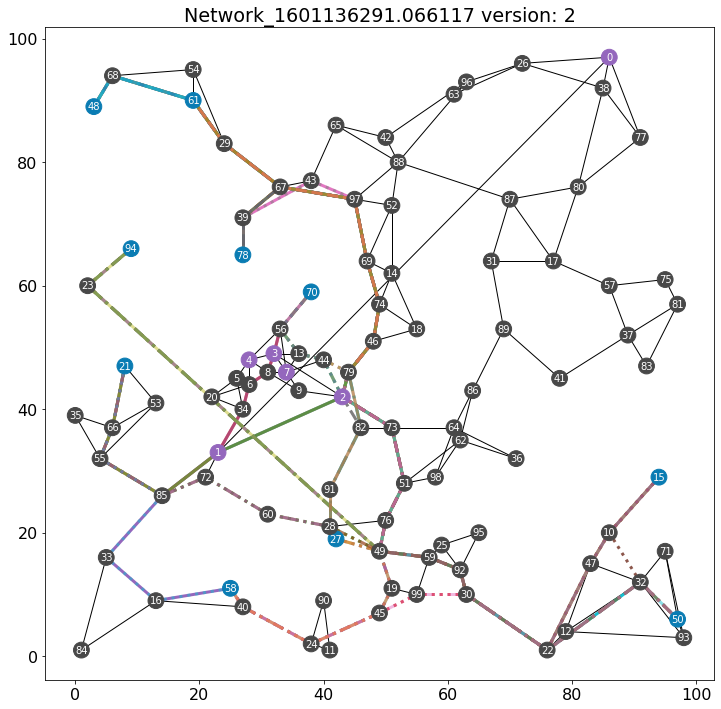

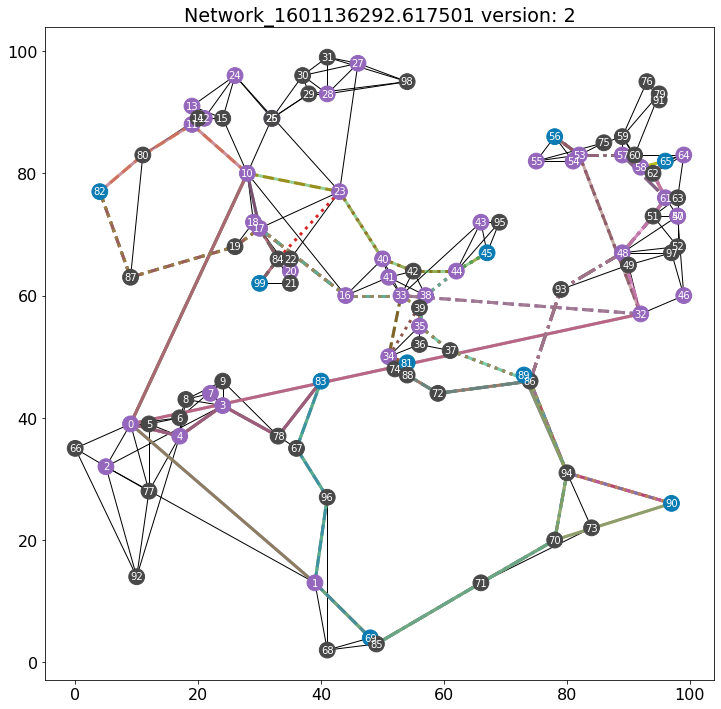

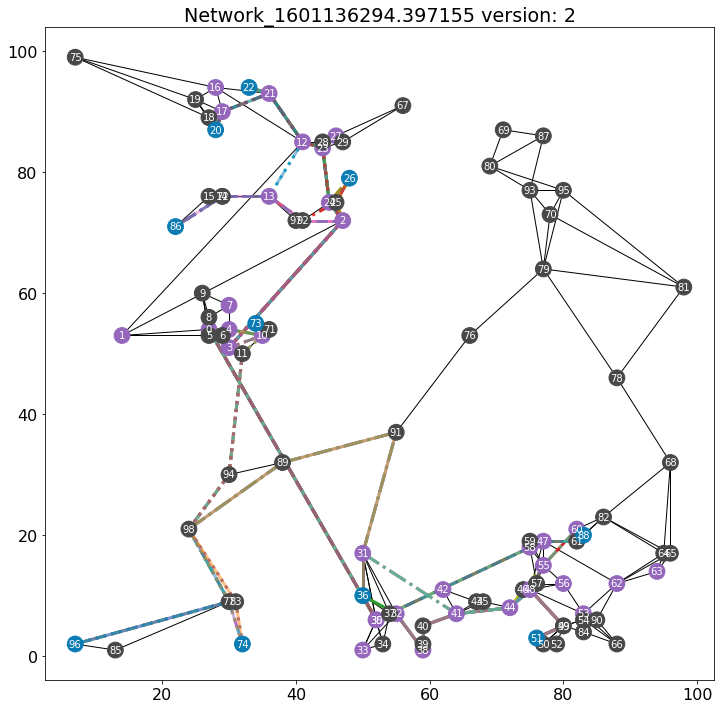

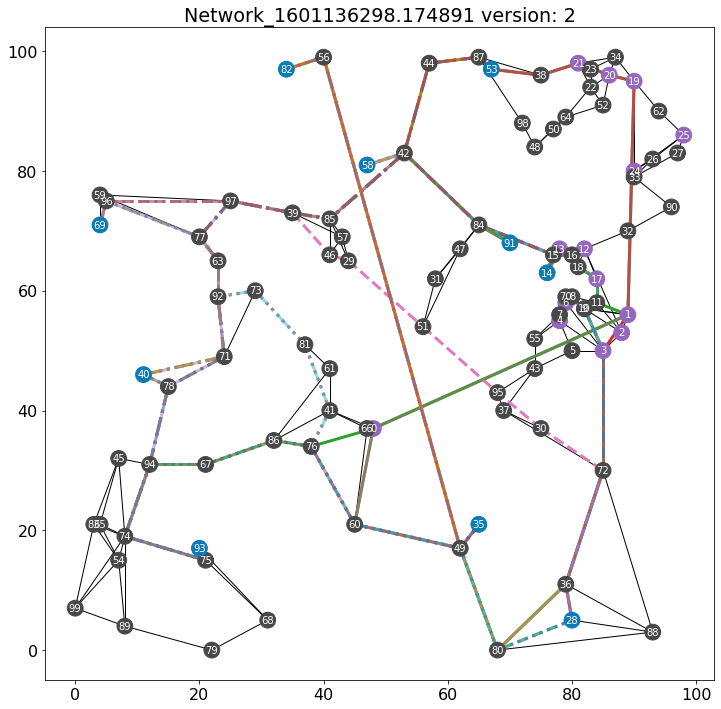

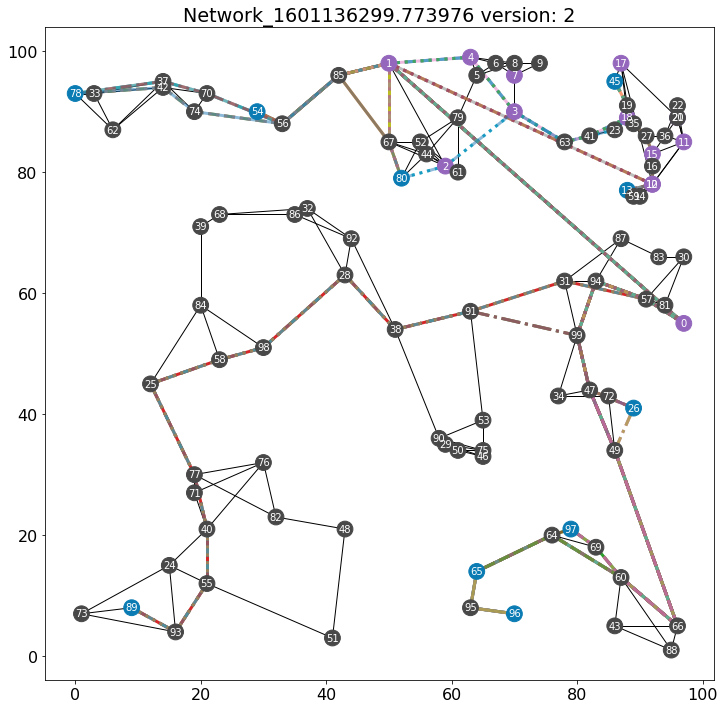

In [46]:
for _ in range(5):
    H = mn.make_detailed_network()
    dn.draw_network(H)

### Working With a Specific Network

After identifying a network worth investigating further, the name and version can be specified to load and display the specific desired network.

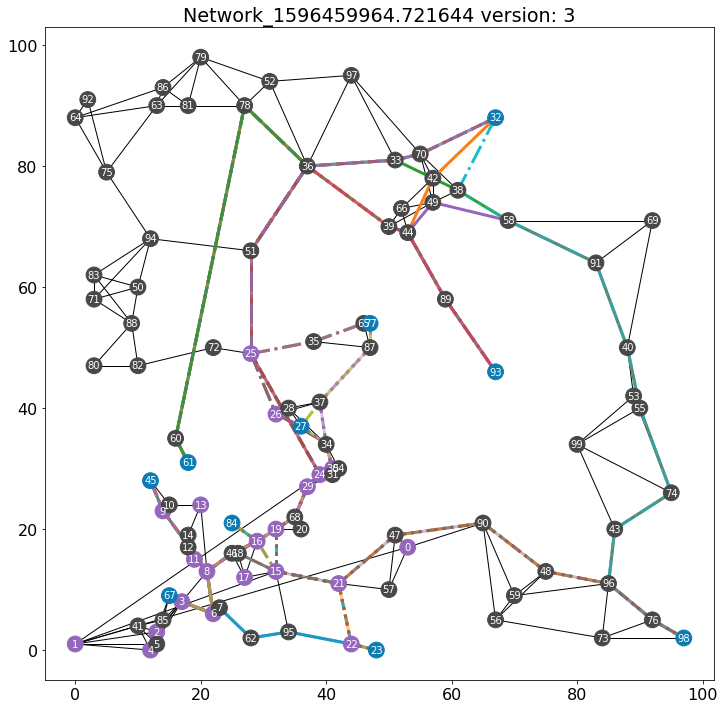

In [49]:
H = mn.load_network('Network_1596459964.721644', 3)
dn.draw_network(H)

#### Highlighting Specific Paths or Characteristics

By default, drawing a network highlights all paths between PS nodes, which can be a bit overwhelming. You can specify the specific ps_pairs you are interested in and only the routes between those pairs will be drawn. Below are the parameters for draw_network:

| Parameter | Default | Purpose |
| --------- | :-----: | :------ |
| graph |  | A networkx graph object must be passed as the initial argument. |
| edge_label | None | The edge characteristic to display on the graph |
| paths | True | Display paths between PS Nodes |
| ps_pairs | \[ \] | A list of pairs of PS nodes between which paths should be drawn (empty list defaults to all paths). |

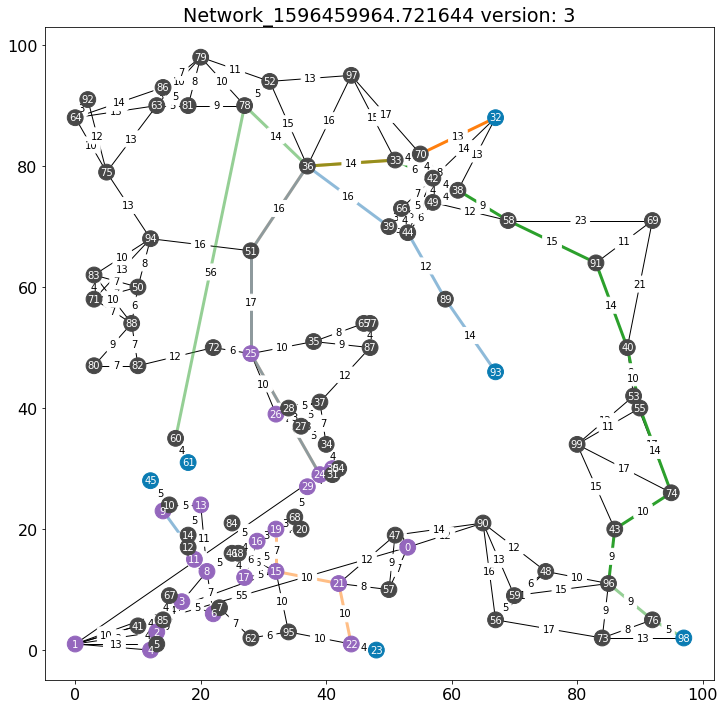

In [50]:
dn.draw_network(H, ps_pairs=[('61', '98'), ('93', '45'), ('23', '32')], edge_label = 'latency')

### Changing Characteristics of a Network

Graphs can be manually tweaked, as needed. The edge values for an individual edge can be modified using change_edge:

| Parameter | Default | Purpose |
| --------- | :-----: | :------ |
| graph |  | A networkx graph object must be passed as the initial argument. |
| edge |  | A string tuple representing the edge must be passed as the second argument. |
| latency | None | If no latency value is provided, the existing latency is retained. |
| packetloss | None | If no packet loss rate is provided, the existing packet loss is retained. |

In [6]:
J = mn.change_edge(H, ('21', '47'), latency=100)

In [ ]:
print(list(H.neighbors('27')), list(H.neighbors('84')), list(H.neighbors('57')), list(H.neighbors('67')), list(H.neighbors('41')), '\n',
      list(H.neighbors('92')), list(H.neighbors('80')), list(H.neighbors('52')), list(H.neighbors('18')), list(H.neighbors('50')))

#### Adding/Removing Edges and PS Nodes

The change_network method allows for manually setting the version of a graph (i.e., setting it to "Final") and adding or removing edges and PS nodes:

| Parameter | Default | Purpose |
| --------- | :-----: | :------ |
| graph |  | A networkx graph object must be passed as the initial argument. |
| version | None | Changes to the graph increment the version by 1, if a numeric version is provided (or the existing version, if no new one is specified). _Note:_ Non-numeric versions do not increment, so they may overwrite existing graphs with the same version name. |
| remove_ps_nodes | \[ \]  | A list of node names (as strings) to remove the PS node designation from. |
| add_ps_nodes | \[ \]  | A list of node names (as strings) to add the PS node designation to. |
| remove_edges | \[ \]  | A list of edges to remove from the graph entirely. |
| add_edges | \[ \]  | A list of edges to add to the graph (edge characteristics can hten by set with change_edge). |

In [ ]:
J = mn.change_network(H, ['27'], ['92'], [], [])

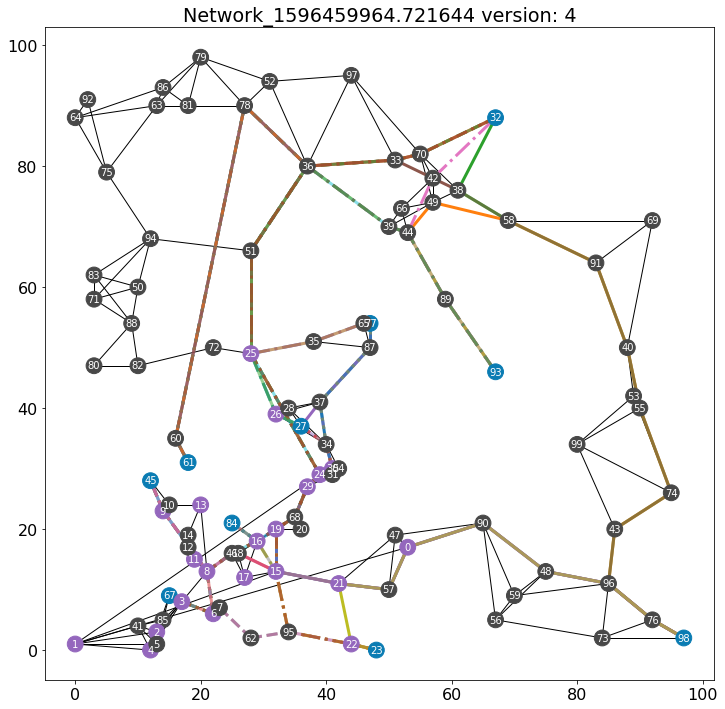

In [7]:
dn.draw_network(J)

### Matching Real Network Distributions

We would like our toy networks to resemble the real network. In order to achieve this, we can compare the distribution of hops, latency and packet loss between PS nodes. If we have a graph we like and it doesn't quite match the distributions, we can modify them with the tools above and see the impact that has on each distribution.

In [59]:
H_lengths, H_latency, H_pl = mn.get_path_lengths(H)
J_lengths, J_latency, J_pl = mn.get_path_lengths(J)

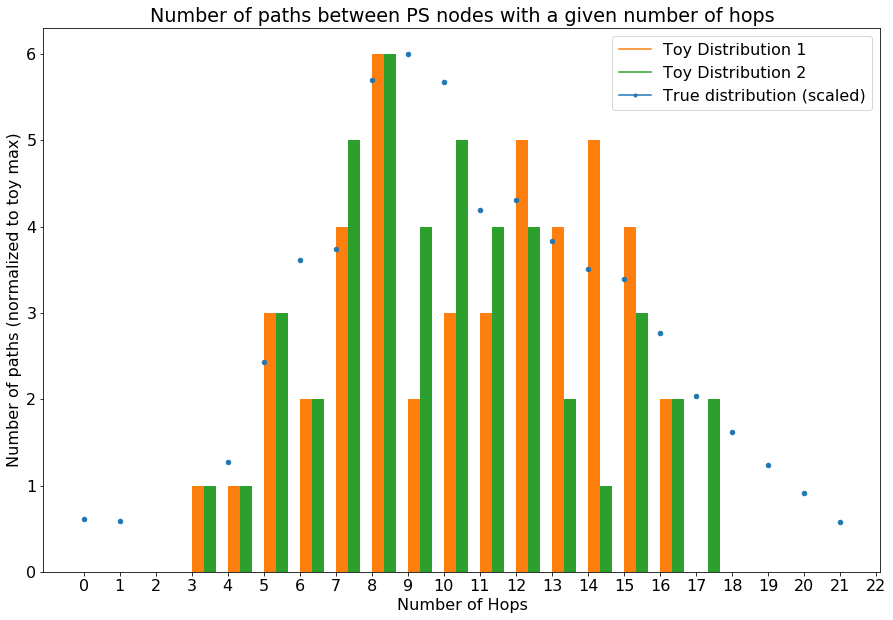

In [69]:
dh.hops_hist("Demo", H_lengths, J_lengths)

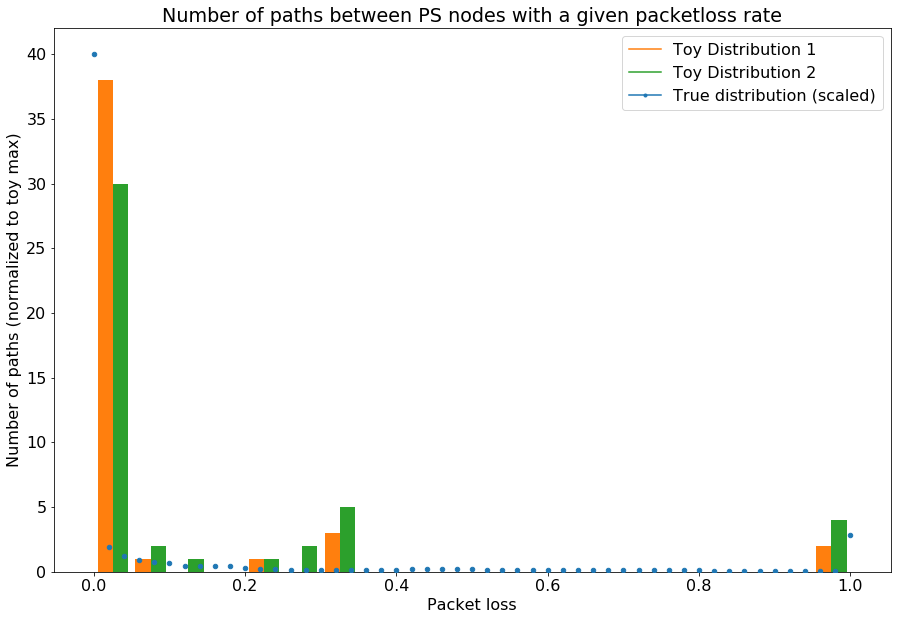

In [64]:
dh.packetloss_hist("test", H_pl, J_pl)

#### Issues with Latency

Latency in the toy network is determined by the Euclidean distance between edges along the path between PS nodes. This placeholder could be tweaked, just like any other measure, but, because of data issues with latency on the real network, we didn't have a good distribution to match it to. As demonstrated below, because of clock sync issues between PS nodes, we have disproportionately low latency and even 0/negative latency (which is impossible!).

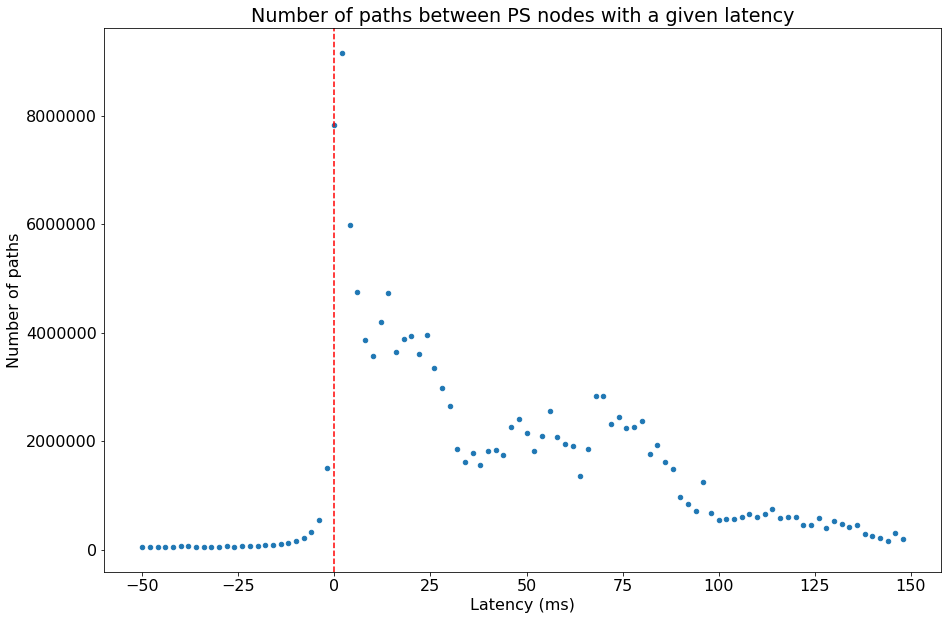

In [62]:
dh.latency_hist("Test")

### Edge Deletion Detection

An extreme event that we would want to identify on a network would be the removal of an important connection between nodes in the network (one that is usually transmitting a lot of data). To infer what edge is deleted, we can look at the trace route data between any impacted pair of PS nodes and note what edges were no longer present at the time of the event. To test whether this is a feasible strategy using our toy network, we can determine the shortest paths between all pairs of PS nodes (a proxy for trace route), remove an edge, then calculate the new shortest paths. A comparison of these two sets of shortest paths enables us to determine what edges were no longer being traversed.

In [70]:
edge_to_remove = (29, 68)
J = mn.change_network(H, remove_edges=[edge_to_remove])

In [71]:
path_changes, edges_no_longer_on_paths = mn.get_path_changes(H, J)

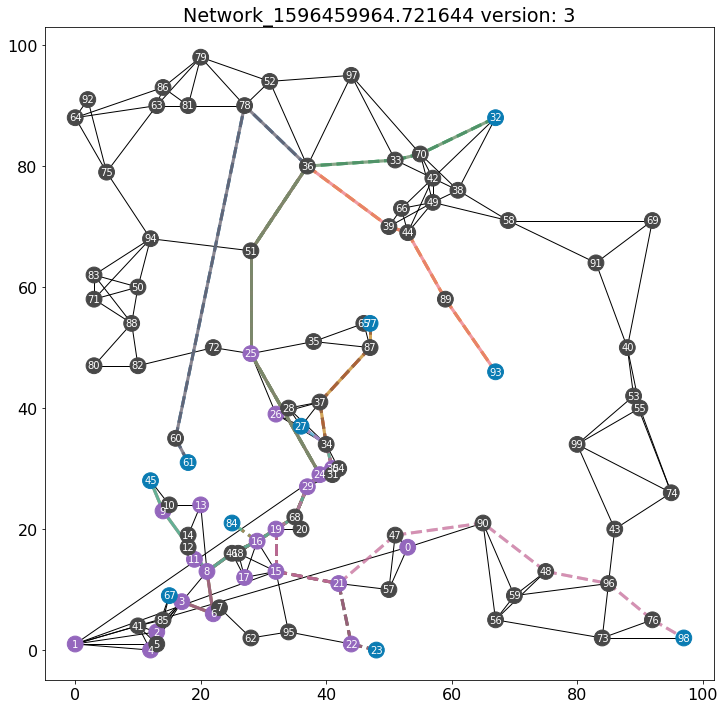

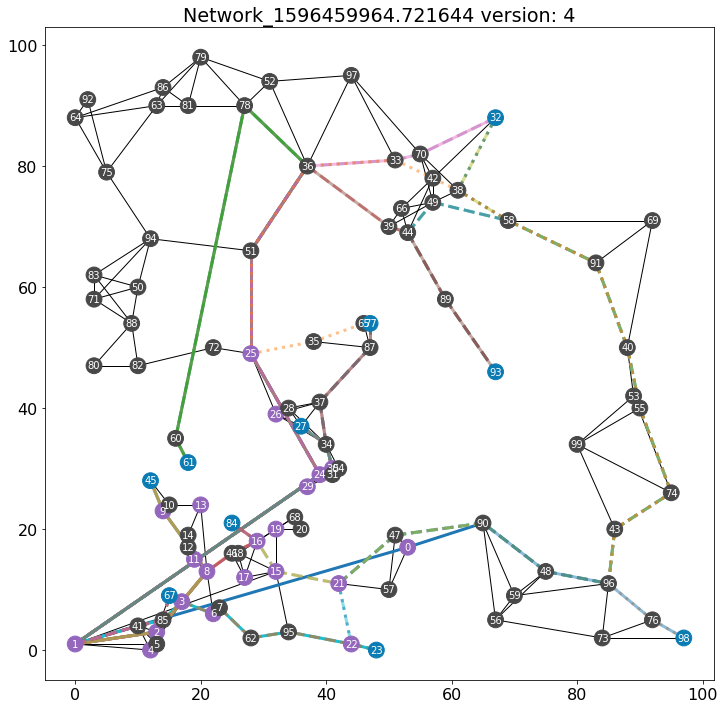

In [72]:
dn.draw_network(H, ps_pairs=[eval(key) for key in path_changes.keys()])
dn.draw_network(J, ps_pairs=[eval(key) for key in path_changes.keys()])

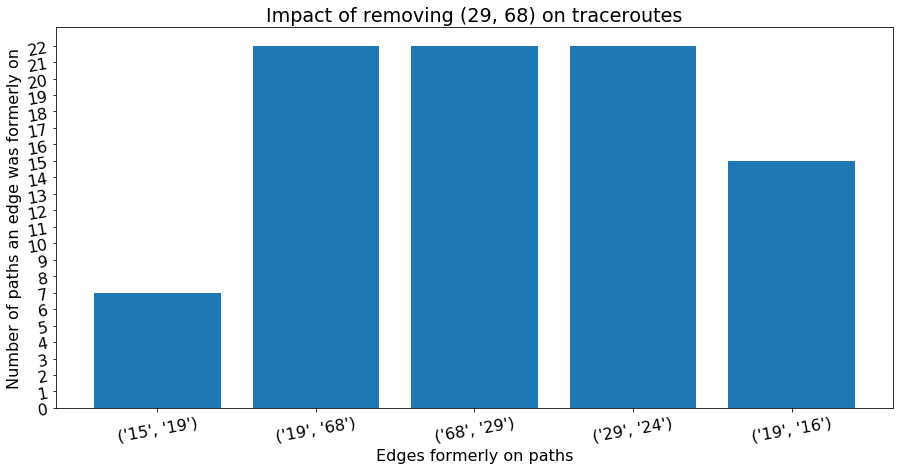

In [73]:
dh.plot_traceroute_changes(edges_no_longer_on_paths, edge_to_remove)

### Ambiguity When Determining Deleted Edges

If we know a single edge is deleted, we only need to look at the edge most frequently removed from paths when considering which edge was deleted. Unfortunately, if an edge is removed, adjacent edges are often not used as a result, so it can appear that multiple edges were removed with equal frequency, in which case it would be ambiguous which of the edges were the deleted ones and which were merely a biproduct of rerouting.

If we don't know that a single edge was deleted, then we can't simply look at the most frequent edge. There are still times when only one edge goes entirely missing from the new graph, once an edge is removed, so it is not impossible to tell which edge was deleted without ambiguity.

To get a sense of how much ambiguity there is in general, edge_deletion_candidates goes through a network and deletes each edge, one at a time, re-calculates shortest routes (a proxy for trace routes on a real network) in each instance, then compares the routes before and after the deletion to see which edges were removed from paths. The number of edges that are tied for having been removed from the most paths are counted in the dictionary trimmed_candidate_count, whereas the total number of edges removed entirely from paths in the new network are counted in candidate_count (disregaring the number of paths an edge is removed from).

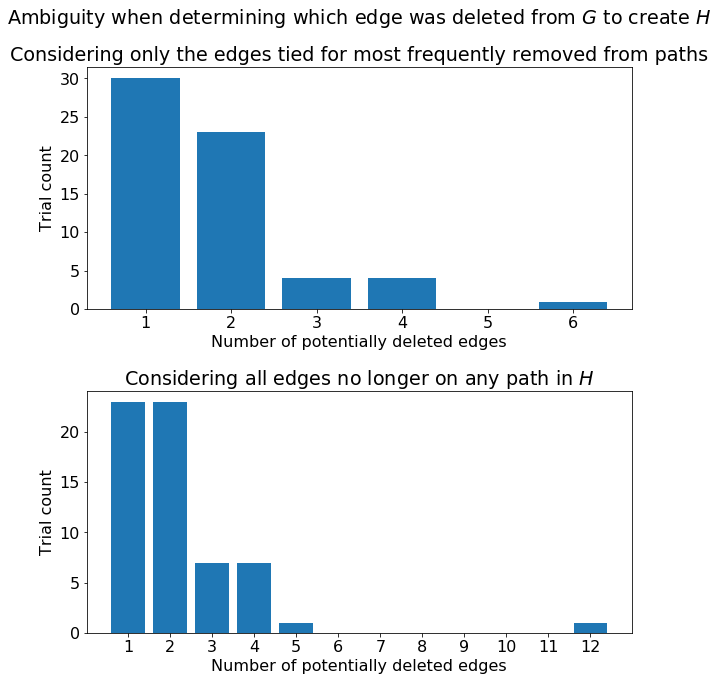

In [74]:
trimmed_candidate_count, candidate_count = mn.edge_deletion_candidates(H)
dh.candidate_hist(H, J, trimmed_candidate_count, candidate_count)

# Testing

Below this point are snippets or code that were used for testing and may or may not still be functional. They are preserved for future reference, but are presented without context.

In [ ]:
len(H.edges)

In [ ]:
H.graph['psnodes']

In [ ]:
dn.draw_network(J)

In [ ]:
np.average([int(length[0]) for length in lengths], weights=[length[1] for length in lengths])

In [ ]:
[e for e in H.edges]

In [ ]:
dh.edge_hist(H)

In [ ]:
G.remove_edge('0','22')

In [ ]:
G = H.copy()

In [ ]:
import networkx as nx

def get_degree(node):
    return H.degree(node)

def key(subgraph):
    return (len(subgraph), H.degree(subgraph[0]))
p = sorted([sorted(list(x), key=get_degree) for x in nx.algorithms.connectivity.edge_kcomponents.bridge_components(H)], key=key)

print(p, [[get_degree(n) for n in l] for l in p])

In [ ]:
import networkx as nx

H.edges[0,70]
# nx.communicability_betweenness_centrality(H)

In [ ]:
H = mn.load_network('Network_1595858874.753222')

In [ ]:
J = mn.load_network('Network_1595541300.335625')

In [ ]:
J.edges

In [ ]:
if 'psnodes' not in J.graph:
    J = mn.add_perfsonar(J, 2, True)

In [ ]:
J = mn.add_shortest_paths(J)

In [ ]:
H = mn.add_shortest_paths(H)

In [ ]:
dn.draw_network(J, paths=True)

In [ ]:
dn.draw_network(H, edge_label='packetloss', paths=True)

In [ ]:
%debug

In [ ]:
perfsonar_nodes = H['perfsonar_nodes']
ps_pairs = combinations(perfsonar_nodes, 2)

print(perfsonar_nodes, ps_pairs)        

for pair in ps_pairs:
    sp.append(nx.shortest_path(H, pair[0], pair[1], weight='latency'))

for path in sp:
    print(path)

In [ ]:
ps_pairs = combinations(H.graph['psnodes'], 2)
print(list(ps_pairs))

In [ ]:
import matplotlib.pyplot as plt



In [ ]:
for edge in H.edges:
    if 'packetloss' in H.edges[edge]:
        print(edge, ': ', H.edges[edge]['packetloss'])

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent

pl = pd.read_csv(PROJECT_ROOT / "data" / "external" / "packetloss_distribution_kibana.csv")

In [ ]:
print(len(pl), pl.shape)

In [ ]:
pl.head()

In [ ]:
print(pl.info())
pl['Count'] = pl['Count'].str.findall('(\d+)').apply("".join)
pl['Count'] = pl['Count'].astype(int)
print(pl.info())

In [ ]:
J.edges

In [ ]:
pl['log'] = np.log(pl['Count'])
pl

In [ ]:
pl['sqrt'] = np.sqrt(pl['Count'])
pl['c_freq'] = pl['Count']/pl['Count'].sum()
pl['log_freq'] = pl['log']/pl['log'].sum()
pl['sqrt_freq'] = pl['sqrt']/pl['sqrt'].sum()
distribution = pl.loc[:,['packet_loss','sqrt_freq']].values.tolist()
print(pl['packet_loss'].tolist())
print(pl['sqrt_freq'].tolist())
print(pl)

In [ ]:
from cycler import cycler
import matplotlib as mpl

sty_cycle = list(mpl.rcParams['axes.prop_cycle'] * cycler('ls', ['-', '--' ,':', '-.']) *
             cycler('lw', [None, 1, 2, 5]))
# cycle = (cycler(letter=['a','b','c','d'])*cycler(number=[1,2,3,4]))

print(list(sty_cycle))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))

N = 15

x = np.arange(N)
y = np.ones_like(x)

sty_cycle = (cycler('ls', ['-', '--' ,':', '-.']) *
             cycler('lw', [None, 1, 2, 3, 4, 5]))

classic = {
    'lines.linewidth': 1.0,
    'lines.dashed_pattern' : [6, 6],
    'lines.dashdot_pattern' : [3, 5, 1, 5],
    'lines.dotted_pattern' : [1, 3],
    'lines.scale_dashes': False}

v2 = {}
#    {'lines.linewidth': 1.5,
#     'lines.dashed_pattern' : [2.8, 1.2],
#     'lines.dashdot_pattern' : [4.8, 1.2, 0.8, 1.2],
#     'lines.dotted_pattern' : [1.1, 1.1],
#     'lines.scale_dashes': True}

def demo(ax, rcparams, title):
    ax.axis('off')
    ax.set_title(title)
    with mpl.rc_context(rc=rcparams):
        for j, sty in enumerate(sty_cycle):
            ax.plot(x, y + j, **sty)

demo(ax1, classic, 'classic')
demo(ax2, {}, 'v2.0')

In [ ]:
import matplotlib.pyplot as plt

cmap = plt.get_cmap('tab20b')
print(cmap[

In [ ]:
J = mn.add_shortest_paths(deepcopy(H))

In [ ]:
J.edges[('14','44')]

In [ ]:
H.edges[('14','44')]

In [ ]:
H = mn.add_shortest_paths(H)

In [ ]:
mn.save_network(H, 1)

In [ ]:
H.graph

In [ ]:
owd = pd.read_csv(PROJECT_ROOT / "data" / "external" / "OWD_histogram.csv")

In [ ]:
owd = owd.rename(columns={'Mean latency [ms]': 'latency'})

In [ ]:
owd['prob'] = owd['Count']/owd['Count'].sum()

latency = delay['latency'].tolist()
latency_prob = delay['prob'].tolist()

delay

In [ ]:
print(latency)
print(latency_prob)
[type(p) for p in latency_prob]

In [ ]:
max([3,5,7])

In [ ]:
for edge in H.edges():
    if 'paths' in H.edges[edge[0], edge[1]]:
        print(H.edges[edge[0], edge[1]]['paths'][0])

In [ ]:
ps_pairs = ["('61', '98')", "('93', '45')", "('32', '23')"]

new_ps_pairs = []
for pair in list(ps_pairs):
    pair = tuple(pair)
    new_ps_pairs.append(str((pair[0], pair[1])))
    new_ps_pairs.append(str((pair[1], pair[0])))
ps_pairs = new_ps_pairs

print(ps_pairs)
print([type(p) for p in ps_pairs])

In [ ]:
('98', '27') in [('23', '61'), ('23', '84'), ('23', '93'), ('23', '32'), ('23', '67'), ('23', '45'), ('23', '77'), ('23', '98'), ('23', '27'), ('61', '84'), ('61', '93'), ('61', '32'), ('61', '67'), ('61', '45'), ('61', '77'), ('61', '98'), ('61', '27'), ('84', '93'), ('84', '32'), ('84', '67'), ('84', '45'), ('84', '77'), ('84', '98'), ('84', '27'), ('93', '32'), ('93', '67'), ('93', '45'), ('93', '77'), ('93', '98'), ('93', '27'), ('32', '67'), ('32', '45'), ('32', '77'), ('32', '98'), ('32', '27'), ('67', '45'), ('67', '77'), ('67', '98'), ('67', '27'), ('45', '77'), ('45', '98'), ('45', '27'), ('77', '98'), ('77', '27'), ('98', '27')]